## 0. python imports

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import f_oneway
from scipy.stats import linregress
import statsmodels.api as sm
from statsmodels.formula.api import ols # ordinary least squares

## 1. data loading

In [4]:
rate = pd.read_csv('./data/rate_by_city.csv')
rate.head()

,Rate,City
0,13.75,1
1,13.75,1
2,13.50,1
3,13.50,1
4,13.00,1


In [5]:
rate.shape

(54, 2)

In [10]:
auto = pd.read_csv('./data/auto-mpg.csv')
auto.head() # mpg stands for miles per gallon, or fuel consumption

,mpg,cylinders,displacement,horse_power,weight,acceleration,model_year,car_name
0,18.0,8,307.0,130.0,3504,12.0,70,"\t""chevrolet chevelle malibu"""
1,15.0,8,350.0,165.0,3693,11.5,70,"\t""buick skylark 320"""
2,18.0,8,318.0,150.0,3436,11.0,70,"\t""plymouth satellite"""
3,16.0,8,304.0,150.0,3433,12.0,70,"\t""amc rebel sst"""
4,17.0,8,302.0,140.0,3449,10.5,70,"\t""ford torino"""


## 2. anova using scipy

In [7]:
rate['city_count'] = rate.groupby('City').cumcount()
rate_pivot = rate.pivot(columns='City', values='Rate', index='city_count')
rate_pivot

City,1,2,3,4,5,6
city_count,,,,,,
0,13.75,14.25,14.00,15.00,14.50,13.50
1,13.75,13.00,14.00,14.00,14.00,12.25
2,13.50,12.75,13.51,13.75,14.00,12.25
3,13.50,12.50,13.50,13.59,13.90,12.00
4,13.00,12.50,13.50,13.25,13.75,12.00
5,13.00,12.40,13.25,12.97,13.25,12.00
6,13.00,12.30,13.00,12.50,13.00,12.00
7,12.75,11.90,12.50,12.25,12.50,11.90
8,12.50,11.90,12.50,11.89,12.45,11.90


https://nikgrozev.com/2015/07/01/reshaping-in-pandas-pivot-pivot-table-stack-and-unstack-explained-with-pictures/

In [8]:
rate_pivot_b = pd.DataFrame({f'city_{i}': rate.loc[rate['City'] == i, 'Rate'].values 
                           for i in rate['City'].unique()})
rate_pivot_b

,city_1,city_2,city_3,city_4,city_5,city_6
0,13.75,14.25,14.00,15.00,14.50,13.50
1,13.75,13.00,14.00,14.00,14.00,12.25
2,13.50,12.75,13.51,13.75,14.00,12.25
3,13.50,12.50,13.50,13.59,13.90,12.00
4,13.00,12.50,13.50,13.25,13.75,12.00
5,13.00,12.40,13.25,12.97,13.25,12.00
6,13.00,12.30,13.00,12.50,13.00,12.00
7,12.75,11.90,12.50,12.25,12.50,11.90
8,12.50,11.90,12.50,11.89,12.45,11.90


In [48]:
?f_oneway

Signature: f_oneway(*args)
Docstring:
Performs a 1-way ANOVA.

The one-way ANOVA tests the null hypothesis that two or more groups have
the same population mean.  The test is applied to samples from two or
more groups, possibly with differing sizes.

Parameters
----------
sample1, sample2, ... : array_like
    The sample measurements for each group.

Returns
-------
statistic : float
    The computed F-value of the test.
pvalue : float
    The associated p-value from the F-distribution.

Notes
-----
The ANOVA test has important assumptions that must be satisfied in order
for the associated p-value to be valid.

1. The samples are independent.
2. Each sample is from a normally distributed population.
3. The population standard deviations of the groups are all equal.  This
   property is known as homoscedasticity.

If these assumptions are not true for a given set of data, it may still be
possible to use the Kruskal-Wallis H-test (`scipy.stats.kruskal`) although
with some loss of power.


In [9]:
f_oneway(*[rate_pivot[i] for i in range(1,7)])

F_onewayResult(statistic=4.8293848737024, pvalue=0.001174551414504048)

In [10]:
f_oneway(*{f'city_{i}': rate.loc[rate['City'] == i, 'Rate'].values 
                           for i in rate['City'].unique()}.values())

F_onewayResult(statistic=4.8293848737024, pvalue=0.001174551414504048)

In [11]:
f_oneway([1, 2, 3], [3, 4, 5], [5, 6, 7])

F_onewayResult(statistic=12.0, pvalue=0.008000000000000002)

In [12]:
sample_data = np.array([[1, 2, 3], [3, 4, 5], [5, 6, 7]]).T
sample_data

array([[1, 3, 5],
       [2, 4, 6],
       [3, 5, 7]])

In [13]:
sample_data[:,1]

array([3, 4, 5])

In [14]:
m = sample_data.shape[1]
n = sample_data.shape[0]

In [15]:
mean = sample_data.mean()

In [16]:
sst = ((sample_data - mean) ** 2).sum()
df_sst = m * n -1 

In [17]:
col_means = sample_data.mean(axis=0)

In [18]:
ssw = ((sample_data - col_means) ** 2).sum()
df_ssw = m * (n - 1)

In [19]:
ssw

6.0

In [20]:
ssb = (((col_means - mean) ** 2) * n).sum()
df_ssb = m - 1

In [21]:
f = (ssb / df_ssb) / (ssw / df_ssw)

In [22]:
f

12.0

In [23]:
m = sample_data.shape[1]
n = sample_data.shape[0]
mean = sample_data.mean()
col_means = sample_data.mean(axis=0)
sst = np.power((sample_data - mean), 2).sum()
sst_df = m * n - 1
ssw = np.power(sample_data - col_means, 2).sum()
ssw_df = (n - 1) * m
ssb = (np.power((col_means - mean), 2) * n).sum()
ssb_df = m -1

In [24]:
f = (ssb / ssb_df)/(ssw / ssw_df)

In [25]:
f

12.0

In [26]:
from scipy.stats import f

In [27]:
1 - f.cdf(12, dfn=df_ssb, dfd=df_ssw)

0.008000000000000007

In [28]:
1 - f.cdf(12, dfn=ssb_df, dfd=ssw_df)

0.008000000000000007

In [29]:
f_oneway(sample_data[:, 0], sample_data[:, 1], sample_data[:, 2])

F_onewayResult(statistic=12.0, pvalue=0.008000000000000002)

https://docs.scipy.org/doc/numpy/user/basics.broadcasting.html

## 3. anova using statsmodels

* https://stackoverflow.com/questions/30650257/ols-using-statsmodel-formula-api-versus-statsmodel-ap
* http://www.statsmodels.org/dev/example_formulas.html
* C(variable) is for categorical variables

In [8]:
formula = 'Rate ~ C(City)'
model = ols(formula=formula, data=rate).fit()

In [31]:
anova_table = sm.stats.anova_lm(model, typ='II')
anova_table

,sum_sq,df,F,PR(>F)
C(City),10.945667,5.0,4.829385,0.001175
Residual,21.758133,48.0,NaN,NaN


In [32]:
f_oneway([3, 2, 1], [5, 3, 4], [5, 6, 7])

F_onewayResult(statistic=12.0, pvalue=0.008000000000000002)

## 4. linear regression using scipy

In [11]:
reg_result = linregress(auto['acceleration'], auto['mpg'])
reg_names = ['slope', 'intercept', 'r_value', 'p_value', 'std_err']
print('\n'.join([f'{reg_names[i]}: {reg_result[i]}' 
                 for i in range(len(reg_result))]))

slope: 1.1912045293502276
intercept: 4.969793004253905
r_value: 0.42028891210165076
p_value: 1.8230915350787203e-18
std_err: 0.129236432831014


In [12]:
x = np.linspace(auto['acceleration'].min(), auto['acceleration'].max(), 50)
y = reg_result[1] + reg_result[0] * x

Plot results:

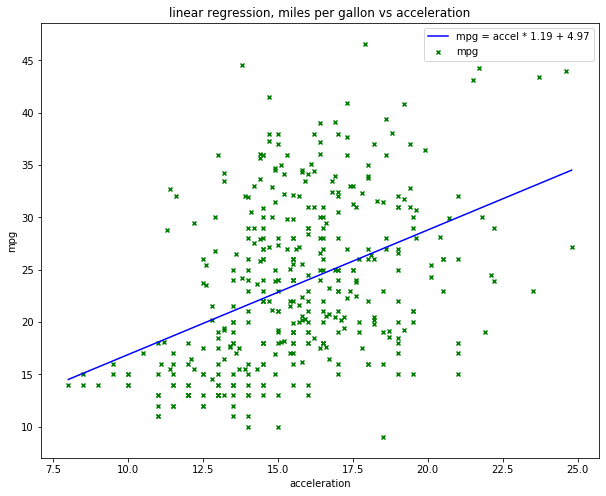

In [13]:
plt.figure(figsize=(10, 8))
plt.plot(x, y, c='b', 
         label=f'mpg = accel * {reg_result[0]:.2f} + {reg_result[1]:.2f}')
plt.scatter(auto['acceleration'], 
            auto['mpg'], 
            marker='x', 
            c='g', 
            s=16,
            label='mpg')
plt.title('linear regression, miles per gallon vs acceleration')
plt.xlabel('acceleration')
plt.ylabel('mpg')
plt.legend()
plt.show()

## 5. linear regression using statsmodels

https://www.theanalysisfactor.com/why-anova-and-linear-regression-are-the-same-analysis/

for only one variable (acceleration)

In [14]:
Y = auto['mpg']
X = sm.add_constant(auto['acceleration'])

model = sm.OLS(Y, X).fit() # ordinary least squares
predictions = model.predict(X)

/home/gurus/miniconda3/envs/jupyter_env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [16]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.177
Model:                            OLS   Adj. R-squared:                  0.175
Method:                 Least Squares   F-statistic:                     84.96
Date:                Wed, 18 Sep 2019   Prob (F-statistic):           1.82e-18
Time:                        10:58:06   Log-Likelihood:                -1343.9
No. Observations:                 398   AIC:                             2692.
Df Residuals:                     396   BIC:                             2700.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            4.9698      2.043      2.432      0.015       0.953       8.987
acceleration     1.1912      0.129      9.217      0.000       0.937       1.445
==============================================================================
Omnibus:                       17.459   Durbin-Watson:                   0.677
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               18.214
Skew:                           0.497   Prob(JB):                     0.000111
Kurtosis:                       2.670   Cond. No.                         91.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

for several variables

In [17]:
auto.columns

Index(['mpg', 'cylinders', 'displacement', 'horse_power', 'weight',
       'acceleration', 'model_year', 'car_name'],
      dtype='object')

In [22]:
X = sm.add_constant(auto[[
#     'acceleration', 
    'cylinders',
    'weight', 
    'horse_power',
    'model_year', 
#     'displacement'
                         ]].apply(lambda x: x.fillna(x.mean())))
Y = auto['mpg']
model = sm.OLS(Y, X).fit()
predictions = model.predict(X)

In [23]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     413.3
Date:                Wed, 18 Sep 2019   Prob (F-statistic):          2.49e-139
Time:                        11:00:25   Log-Likelihood:                -1054.2
No. Observations:                 398   AIC:                             2118.
Df Residuals:                     393   BIC:                             2138.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         -13.7621      4.164     -3.305      0.001     -21.949      -5.575
cylinders      -0.0771      0.241     -0.320      0.749      -0.551       0.396
weight         -0.0065      0.001    -12.453      0.000      -0.007      -0.005
horse_power    -0.0016      0.010     -0.163      0.870      -0.021       0.017
model_year      0.7510      0.052     14.508      0.000       0.649       0.853
==============================================================================
Omnibus:                       42.055   Durbin-Watson:                   1.215
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               68.887
Skew:                           0.670   Prob(JB):                     1.10e-15
Kurtosis:                       4.536   Cond. No.                     7.46e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.46e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

* check table for significant variables (model_year, weight)

¿car brand? not suitable for linear regression out of the box, one hot encoding needed!

In [24]:
auto['brand'] = auto['car_name'] \
                .str.lstrip('\t') \
                .str.strip('""') \
                .str.split(' ') \
                .str[0].astype('category')

pd.get_dummies(auto['brand'].head())

brand,amc,audi,bmw,buick,cadillac,capri,chevroelt,chevrolet,chevy,chrysler,...,renault,saab,subaru,toyota,toyouta,triumph,vokswagen,volkswagen,volvo,vw
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Alternative using scikit-learn:

In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

X = auto[[
#     'acceleration', 
#     'cylinders',
    'weight', 
#     'horse_power',
    'model_year', 
#     'displacement'
                         ]]

y = auto['mpg']

model = LinearRegression(fit_intercept=False)
model.fit(X, y)
predictions = model.predict(X)

print(r2_score(y_true=y, y_pred=predictions))
print(model.coef_)
print(model.intercept_)

0.8016334565738041
[-0.00700653  0.58352372]
0.0


In [46]:
np.array([1, 2, 3, 3, 4, 5, 5, 6, 7]).mean()

4.0